In [1]:
import sys
import pickle
import threading
if sys.version_info.major == 2:
    from Queue import Queue
else:
    from queue import Queue

import keras
import theano
import numpy as np
import theano.tensor as T
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Merge, Input, Lambda, merge, Layer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from environment import Environment
from priority_buffer import PriorityBuffer

Using Theano backend.


In [3]:
class A(Layer):
    
    # inputs are L and U and mu (in that order)
    def __init__(self, u_size, **kwargs):
        self.u_size = u_size
        self.lower_size = int(u_size * (u_size + 1) / 2.0)
        self.l_idx = list(range(self.lower_size))
        super(A, self).__init__(**kwargs)

        # Some precalculating for call()
        self.diag_idx = list(range(u_size))
        self.lower_idx1 = []
        self.lower_idx2 = []
        for i in self.diag_idx:
            for j in range(i):
                self.lower_idx1.append(i)
                self.lower_idx2.append(j)

    def build(self, input_shape):
        super(A, self).build(self.lower_size + self.u_size)
        
    def get_output_shape_for(self, input_shape):
        return (None, 1)
        
    def _p(self, x):
        l = T.zeros((x.shape[0], self.u_size, self.u_size))
        l = T.set_subtensor(l[:, self.diag_idx, self.diag_idx], T.exp(x[:, self.diag_idx]))
        if self.u_size > 1:
            l = T.set_subtensor(
                l[:, self.lower_idx1, self.lower_idx2],
                x[:, self.u_size:self.u_size + self.u_size]
            )
        return K.batch_dot(l, K.permute_dimensions(l, [0, 2, 1]))
    
    def call(self, x, mask=None):
        p = self._p(x[:, :self.lower_size])
        u = x[:, self.lower_size:self.lower_size + self.u_size]
        mu = x[:, self.lower_size + self.u_size:]
        d = K.expand_dims(u - mu, -1)
        a = -T.batched_dot(K.batch_dot(K.permute_dimensions(d, (0,2,1)), p), d)
        return a.reshape((x.shape[0], 1))
    
u_size = 2
input_size = 3 + 2 * u_size
x = Input(shape=(input_size, ), name='x')
a = A(u_size=u_size, name='A')(x)
xs = np.random.randn(10, input_size)
a.shape[1]
m = Model(input=x, output=a)
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x (InputLayer)                   (None, 7)             0                                            
____________________________________________________________________________________________________
A (A)                            (None, 1)             0           x[0][0]                          
Total params: 0
Trainable params: 0
Non-trainable params: 0
____________________________________________________________________________________________________


In [4]:
class NAFNet2():
    
    def __init__(self, x_size, u_size, hidden_size=100):
        self.x_size = x_size
        self.u_size = u_size
        self.hidden_size = hidden_size
    
        self.x = Input(shape=(self.x_size, ), name='x')
        fc1 = Dense(input_dim=self.x_size, output_dim=self.hidden_size, activation='relu', name='fc1')(self.x)
        fc2 = Dense(input_dim=self.hidden_size, output_dim=self.hidden_size, activation='relu', name='fc2')(fc1)
        
        v = Dense(input_dim=self.hidden_size, output_dim=1, name='v')(fc2)
        self.v = Model(input=self.x, output=v)
        self.v.build(input_shape=(self.x_size, ))
        
        mu = Dense(input_dim=self.hidden_size, output_dim=2, activation='tanh', name='mu_dense')(fc2)
        self.mu = Model(input=self.x, output=mu)
        self.mu.build(input_shape=(self.x_size, ))
        
        l_all = Dense(
            input_dim=self.hidden_size,
            output_dim=int(self.u_size * (self.u_size + 1) / 2.0)
        )(fc2)
        
        self.l_all = Model(input=self.x, output=l_all)
        
        u = Input(shape=(self.u_size, ), name='u')
        a = A(u_size=self.u_size, name='A')
        
        
        self.u = Model(input=u, output=u, name='u_model')
        self.a = Sequential(
            layers=[
                Merge([self.l_all, self.u, self.mu], mode='concat', name='merge_for_p'),
                a
            ]
        )
        
        self.q = Sequential(layers=[Merge([self.a, self.v])])
        adam = Adam(lr=0.0001)
        self.q.compile(loss='mse', optimizer=adam)
        
nn2 = NAFNet2(x_size=4, u_size=2)

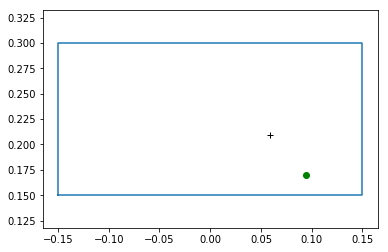

In [5]:
def random_in_range(a, b):
    if b < a:
        raise ValueError('b should not be less than a')
    return np.random.rand() * (b - a) + a

e = Environment()
e.plot()
plt.show()

def create_state_vector(eef_x, eef_y, goal_x, goal_y):
    return np.array([
        [eef_x, eef_y, goal_x, goal_y]
    ], dtype=np.float32)

In [ ]:
print(e.move(0.10, -0.05))
e.plot()
plt.show()

In [ ]:
def plot_v(nn, goal_x=0.0, goal_y=0.2):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    xs = np.linspace(-0.15, 0.15, 40)
    ys = np.linspace(0.10, 0.30, 40)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    u = np.array([[]])
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            zss[j, i] = nn2.v.predict(create_state_vector(x, y, goal_x, goal_y))[0, 0]
    ax.plot_surface(xss, yss, zss, cmap='viridis')
    plt.show()
    
def plot_v_heat(nn, goal_x=0.0, goal_y=0.2):
    xs = np.linspace(-0.15, 0.15, 12)
    ys = np.linspace(0.10, 0.30, 12)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            zss[len(ys) - j - 1, i] = nn2.v.predict(create_state_vector(x, y, goal_x, goal_y))[0, 0]
    plt.imshow(zss, cmap='jet', interpolation='gaussian', aspect='auto',
               extent=[-0.15, 0.15, 0.15, 0.30])
    plt.plot(goal_x, goal_y, 'ko', markersize=8)
    plt.plot(goal_x, goal_y, 'ro', markersize=6)
    plt.colorbar().set_label('$V(\mathbf{x})$')
    
plot_v_heat(nn2)
plt.show()

In [ ]:
def plot_pi(nn, goal_x=0.0, goal_y=0.2):
    for x in np.linspace(-0.15, 0.15, 20):
        for y in np.linspace(0.15, 0.30, 20):
            X = np.array([[x, y, goal_x, goal_y]])
            dx, dy = 0.1 * nn.mu.predict(X)[0, :]
            plt.arrow(x, y, dx / 1.2, dy / 1.2)
            plt.plot(goal_x, goal_y, 'ko', markersize=8)
            plt.plot(goal_x, goal_y, 'ro', markersize=6)
    plt.title('$\mathbf{\mu(x)}$')
    plt.xlim(-0.15, 0.15)
    plt.ylim(0.15, 0.30)
    
start = np.array([-0.10, 0.28])
end = np.array([0.10, 0.17])
n_steps = 4
plt.figure(figsize=(12, 14))
for i in range(n_steps):
    goal_x, goal_y = start + i / (n_steps - 1) * (end - start)
    plt.subplot(420 + 2 * i + 1)
    plot_pi(nn2, goal_x=goal_x, goal_y=goal_y)
    plt.subplot(420 + 2 * i + 2)
    plot_v_heat(nn2, goal_x=goal_x, goal_y=goal_y)
plt.savefig('moving_goal_summary.pdf')
plt.show()

In [ ]:
# batch_size = 512
#replay_buffer = PriorityBuffer(2 ** 18)
gamma = 0.98
epsilon = 0.1

#todo: check importance weights annealing if they seem to matter
#   2: try moving goal

n_iterations = 256.0
#a = 0
for a in range(a, int(n_iterations)):
    e.reset()
    for b in range(batch_size):
        x1 = (e.eef_x, e.eef_y, e.goal_x, e.goal_y)
        mu = 0.1 * nn2.mu.predict(create_state_vector(*x1))
        noise = np.random.randn(1, 2) / 30.0
        reward = e.move(*(mu + noise)[0, :])
        x2 = (e.eef_x, e.eef_y, e.goal_x, e.goal_y)
        replay_buffer.add({
            'x1': x1,
            'x2': x2,
            'u': mu + noise,
            'r': reward
        }).set_value(10.0)
        if reward == -2:
            e.reset()
        if np.sqrt((e.eef_x - e.goal_x) ** 2 + (e.eef_y - e.goal_y) ** 2) < 0.01:
            e.reset()
        
    for i in range(32):
        X = np.zeros((batch_size, 4))
        Xp = np.zeros((batch_size, 4))
        U = np.zeros((batch_size, 2))
        R = np.zeros((batch_size, 1))
        exp_nodes = []
        for b in range(batch_size):
            sample = replay_buffer.sample()
            exp_nodes.append(sample)
            X[b, :] = create_state_vector(*sample.data['x1'])
            Xp[b, :] = create_state_vector(*sample.data['x2'])
            R[b, :] = sample.data['r']
            U[b, :] = sample.data['u']
        V = nn2.v.predict(Xp)
        Y = R + gamma * V
        Q = nn2.q.predict([X, U])
        [node.set_value(abs(delta) + epsilon) for node, delta in zip(exp_nodes, (Q - Y)[:, 0])]
        beta = np.exp((a - n_iterations) / (0.1 * n_iterations))
        sample_weights = np.array([1.0 / node.value for node in exp_nodes]) ** beta
        sample_weights /= sample_weights.sum()
        if a % 1 == 0 and i == 31:
            print(replay_buffer)
            print('beta:', beta)
            nn2.q.fit([X, U], Y, verbose=1, nb_epoch=10, sample_weight=sample_weights)
            plt.figure(figsize=(8, 6))
            for x in np.linspace(-0.15, 0.15, 20):
                for y in np.linspace(0.10, 0.30, 20):
                    X = np.array([[x, y, 0.0, 0.20]])
                    dx, dy = 0.1 * nn2.mu.predict(X)[0, :]
                    plt.plot(0.0, 0.2, 'ro')
                    plt.arrow(x, y, dx / 2, dy / 2)
            print(dx, dy)
            plt.xlim(-0.15, 0.15)
            plt.ylim(0.10, 0.30)
            plt.show()
            plot_v_heat(nn2)
        else:
            nn2.q.fit([X, U], Y, verbose=0, nb_epoch=10, sample_weight=sample_weights)